## 2.1 ConvNet On CIFAR10

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda:0


In [2]:
# Data augmentation and normalization for training
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Just normalization for validation/test
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# CIFAR10 Dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                      download=True, transform=train_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                        shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                     download=True, transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=128,
                                       shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170M/170M [00:14<00:00, 11.9MB/s] 


Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        
        # Batch normalization layers
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        
        # Dropout layer
        self.dropout = nn.Dropout(0.25)
        
        # Fully connected layers
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        # First conv block
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        
        # Second conv block
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        
        # Third conv block
        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        
        # Fully connected layers
        x = x.view(-1, 128 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

# Create the network and move it to GPU if available
net = Net().to(device)

In [4]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def plot_training_history(train_losses, val_losses, val_accuracies):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))
    
    # Plot losses
    ax1.plot(train_losses, label='Training Loss')
    ax1.plot(val_losses, label='Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.set_title('Training and Validation Losses')
    
    # Plot accuracy
    ax2.plot(val_accuracies, label='Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.set_title('Validation Accuracy')
    
    plt.tight_layout()
    plt.show()

Epoch 1: Train Loss: 1.652, Val Loss: 1.304, Val Acc: 52.05%
Epoch 2: Train Loss: 1.374, Val Loss: 1.176, Val Acc: 56.67%
Epoch 3: Train Loss: 1.255, Val Loss: 1.067, Val Acc: 60.88%
Epoch 4: Train Loss: 1.179, Val Loss: 0.960, Val Acc: 65.35%
Epoch 5: Train Loss: 1.124, Val Loss: 0.921, Val Acc: 67.63%
Epoch 6: Train Loss: 1.073, Val Loss: 0.838, Val Acc: 69.98%
Epoch 7: Train Loss: 1.044, Val Loss: 0.795, Val Acc: 71.46%
Epoch 8: Train Loss: 1.010, Val Loss: 0.773, Val Acc: 72.57%
Epoch 9: Train Loss: 0.986, Val Loss: 0.762, Val Acc: 73.15%
Epoch 10: Train Loss: 0.960, Val Loss: 0.764, Val Acc: 72.94%
Epoch 11: Train Loss: 0.937, Val Loss: 0.716, Val Acc: 74.62%
Epoch 12: Train Loss: 0.921, Val Loss: 0.709, Val Acc: 75.06%
Epoch 13: Train Loss: 0.913, Val Loss: 0.700, Val Acc: 75.24%
Epoch 14: Train Loss: 0.885, Val Loss: 0.687, Val Acc: 76.03%
Epoch 15: Train Loss: 0.879, Val Loss: 0.689, Val Acc: 75.94%
Epoch 16: Train Loss: 0.868, Val Loss: 0.661, Val Acc: 76.63%
Epoch 17: Train L

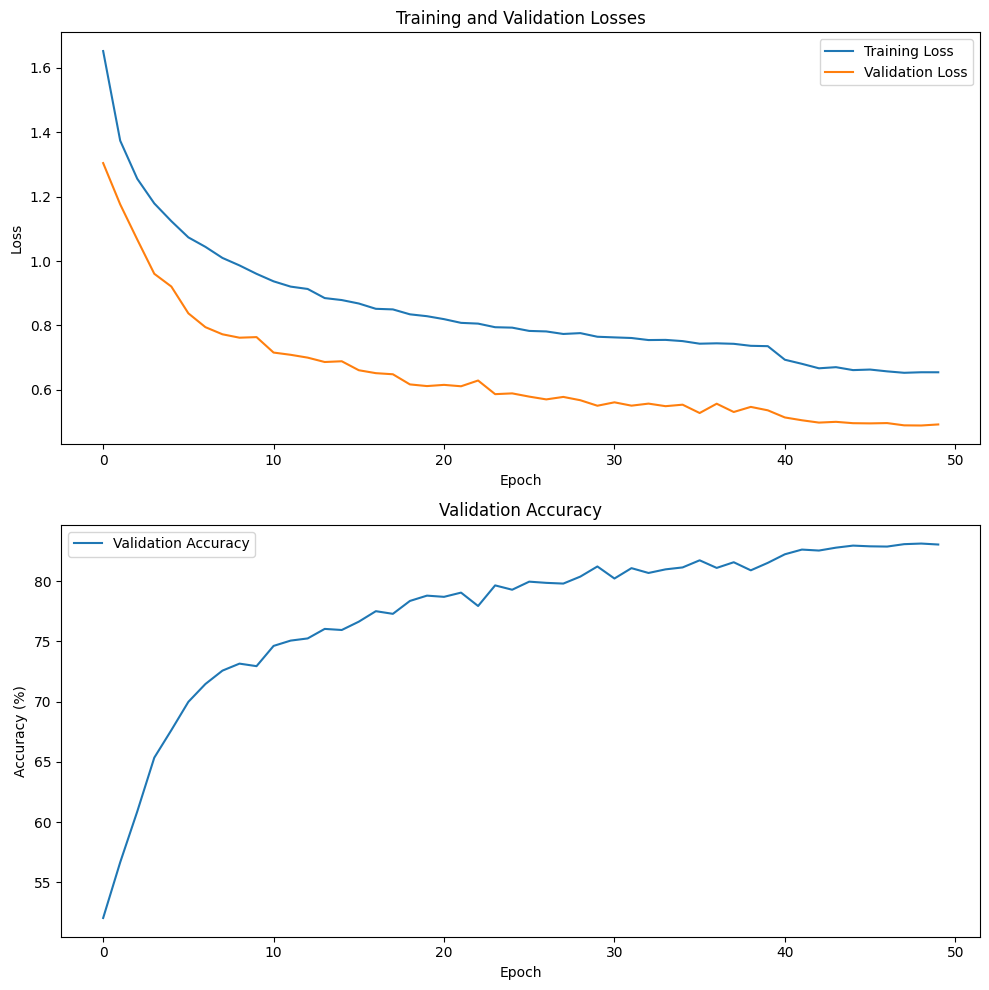

In [5]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.1)

# Training parameters
n_epochs = 50
best_acc = 0
train_losses = []
val_losses = []
val_accuracies = []

# Training loop
for epoch in range(n_epochs):
    net.train()
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    epoch_loss = running_loss / len(trainloader)
    train_losses.append(epoch_loss)
    
    # Validation phase
    net.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    epoch_val_loss = val_loss / len(testloader)
    val_losses.append(epoch_val_loss)
    
    acc = 100. * correct / total
    val_accuracies.append(acc)
    
    print(f'Epoch {epoch+1}: Train Loss: {epoch_loss:.3f}, Val Loss: {epoch_val_loss:.3f}, Val Acc: {acc:.2f}%')
    
    # Save best model
    if acc > best_acc:
        best_acc = acc
        torch.save(net.state_dict(), 'best_model.pth')
        
    # Adjust learning rate
    scheduler.step(epoch_val_loss)

print('Finished Training')

# Plot training history
plot_training_history(train_losses, val_losses, val_accuracies)

C:\Users\sf\AppData\Local\Temp\ipykernel_27400\935041529.py:40: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load('best_model.pth'))


Accuracy on test set: 83.11%


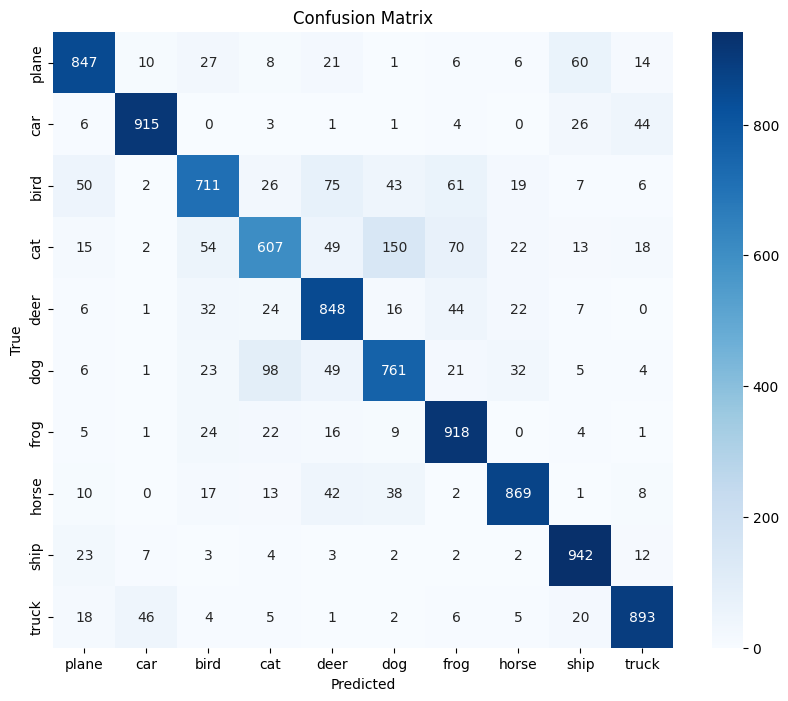

Accuracy of plane: 84.70%
Accuracy of car: 91.50%
Accuracy of bird: 71.10%
Accuracy of cat: 60.70%
Accuracy of deer: 84.80%
Accuracy of dog: 76.10%
Accuracy of frog: 91.80%
Accuracy of horse: 86.90%
Accuracy of ship: 94.20%
Accuracy of truck: 89.30%


In [6]:
def evaluate_model():
    net.eval()
    all_preds = []
    all_labels = []
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            _, predicted = outputs.max(1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    accuracy = 100 * correct / total
    print(f'Accuracy on test set: {accuracy:.2f}%')
    
    # Create confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()
    
    # Per-class accuracy
    for i in range(10):
        class_correct = cm[i][i]
        class_total = cm[i].sum()
        print(f'Accuracy of {classes[i]}: {100 * class_correct / class_total:.2f}%')

# Load best model and evaluate
net.load_state_dict(torch.load('best_model.pth'))
evaluate_model()